In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

%matplotlib inline

sns.set_theme(style="whitegrid")

# Loading and exploring the data

In [2]:
df = pd.read_csv('ab_test_ensembles.csv')
df.head(10)

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
5,426f77eb-8739-43b6-999c-aecd14d9f346,2022-05-10 15:20:49.083499,control,standard,0,United Kingdom,42-49,registered_user
6,aa9d93c5-a18f-444a-a522-7e7145835362,2022-05-19 03:26:46.940749,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,registered_user
7,de214e30-9b8d-44cf-87b1-16917f3e1c89,2022-05-17 01:48:29.539573,control,standard,0,United Kingdom,18-25,registered_user
8,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
9,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [4]:
df.isna().sum()

user_id      0
timestamp    0
group        0
variants     0
converted    0
location     0
age_group    0
user_type    0
dtype: int64

# Power analysis

In [5]:
print('Baseline conversation level = {:.3f}'.format(df[df['group'] == 'control']['converted'].mean()))

Baseline conversation level = 0.120


In [6]:
effect_size = sms.proportion_effectsize(0.12, 0.14) # Calculating effect size
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1) # Calculating sample size needed
required_n = ceil(required_n) # Rounding up
print("We need {} users in both control and treatment group".format(required_n))

We need 4433 users in both control and treatment group


In [7]:
print('Size of control group = ',len(df[df['group'] == 'control']))
print('Size of treatment group = ',len(df[df['group'] == 'treatment']))

Size of control group =  147202
Size of treatment group =  147276


Hence we have a sufficient number of users

# Filtering users for each group

In [8]:
print('There are {} non-unique users'.format(sum(df['user_id'].value_counts() > 1)))

There are 0 non-unique users


In [9]:
# Calculating users who see different versions by groups
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311



# Z-test and confidence intervals


## Functions

In [10]:
def comp_cr(ab_test, gb):
    conversion_rates = ab_test.groupby(gb)['converted']

    std = lambda x: np.std(x, ddof=1) # Std. deviation of the proportion
    std_error = lambda x: stats.sem(x, ddof=1) # Std. error of the proportion (std / sqrt(n))

    conversion_rates = conversion_rates.agg([np.mean, std, std_error])

    conversion_rates.columns = ['CR_mean', 'std', 'std_error']
    return conversion_rates.style.format('{:.3f}')

def plot_rate(ab_test, gb):
    plt.figure(figsize=(8,6));
    sns.barplot(x=ab_test[gb], y=ab_test['converted'], ci=False);
    plt.ylim(0, 0.17);
    plt.title('Conversion rate by model type', pad=20)
    plt.xlabel('Group', labelpad=15);
    plt.ylabel('Converted (proportion)', labelpad=15);
    
    
def print_z_stat(conv1, conv2):

    n1 = conv1.count()
    n2 = conv2.count()
    successes = [conv1.sum(), conv2.sum()]
    nobs = [n1, n2]

    z_stat, pval = proportions_ztest(successes, nobs=nobs)
    (lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

    print(f'Z-statistic: {z_stat:.2f}')
    print(f'p-value: {pval:.3f}')
    print(f'CI 95% for the first group: [{lower_con:.3f}, {upper_con:.3f}]')
    print(f'CI 95% for the second group: [{lower_treat:.3f}, {upper_treat:.3f}]')

## By group (control/treatment)

In [11]:
# Filtering users whe see wrong variants

control_group = df[(df['group'] == 'control') & (df['variants'] == 'standard')]
treatment_group = df[(df['group'] == 'treatment') & (df['variants'] == 'svm_ensemble_v_1_22')]

ab_test = pd.concat([control_group, treatment_group], axis=0)
ab_test.reset_index(inplace=True, drop=True)
pd.crosstab(ab_test['group'], ab_test['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,0
treatment,0,145311


,CR_mean,std,std_error
group,,,
control,0.120,0.325,0.001
treatment,0.119,0.324,0.001


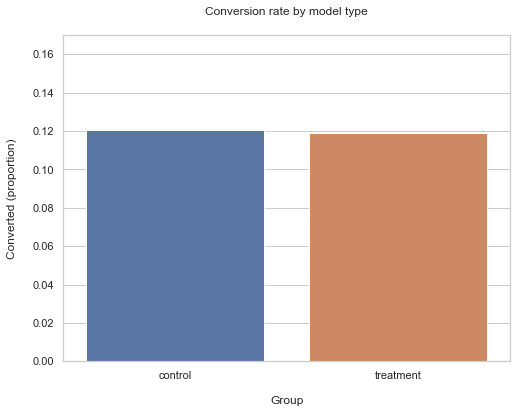

In [12]:
cr = comp_cr(ab_test, gb='group')
plot_rate(ab_test, gb = 'group')
cr

In [13]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

print_z_stat(control_results, treatment_results)

Z-statistic: 1.31
p-value: 0.190
CI 95% for the first group: [0.119, 0.122]
CI 95% for the second group: [0.117, 0.120]


p-value > 0.05, hence we can't accept the alternative hypothesis.
Also confidence intervals include baseline value of 12% conversion rate.

It makes no sense for the company to introduce a new version of the service.


# Groupping by user type (registered/new)

In [14]:
pd.crosstab(df['user_type'], df['variants'])

variants,standard,svm_ensemble_v_1_22
user_type,,
new_user,73797,73441
registered_user,73442,73798


We have a sufficient number of users (required_n = 4433)

## Registered

,CR_mean,std,std_error
variants,,,
standard,0.120,0.325,0.001
svm_ensemble_v_1_22,0.120,0.325,0.001


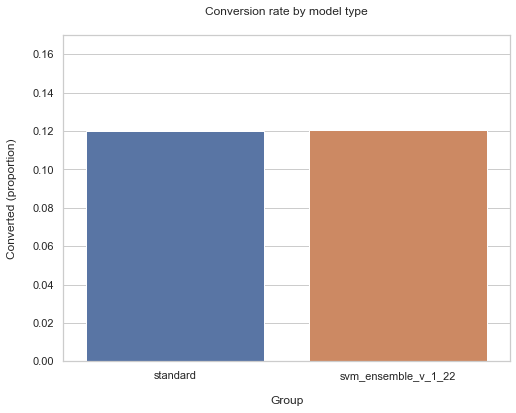

In [15]:
registered = df[df['user_type'] == 'registered_user']
cr = comp_cr(registered, gb='variants')
plot_rate(registered, gb = 'variants')
cr

In [16]:
conv1 = registered[registered['variants'] == 'standard']['converted']
conv2 = registered[registered['variants'] == 'svm_ensemble_v_1_22']['converted']
print_z_stat(conv1, conv2)

Z-statistic: -0.34
p-value: 0.735
CI 95% for the first group: [0.118, 0.122]
CI 95% for the second group: [0.118, 0.123]


p-value > 0.05, hence we can't accept the alternative hypothesis.
Also confidence intervals include baseline value of 12% conversion rate.

It makes no sense for the company to introduce a new version of the service for registered users.


# New users

,CR_mean,std,std_error
variants,,,
standard,0.121,0.326,0.001
svm_ensemble_v_1_22,0.117,0.322,0.001


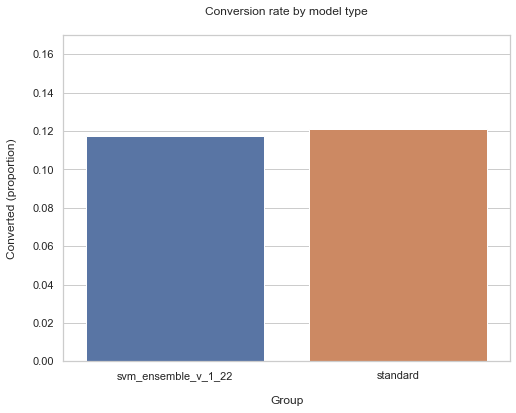

In [17]:
new_users = df[df['user_type'] == 'new_user']
cr = comp_cr(new_users, gb='variants')
plot_rate(new_users, gb = 'variants')
cr

In [18]:
conv1 = new_users[new_users['variants'] == 'standard']['converted']
conv2 = new_users[new_users['variants'] == 'svm_ensemble_v_1_22']['converted']
print_z_stat(conv1, conv2)

Z-statistic: 2.28
p-value: 0.023
CI 95% for the first group: [0.119, 0.123]
CI 95% for the second group: [0.115, 0.120]


p-value < 0.05, hence we can accept the alternative hypothesis.
For the new users, the new option only worsens the conversion, confidence internals lower than for the old version.
It makes no sense for the company to introduce a new version of the service.
